## Common Patterns in DP
### Iteration in the recurence relation
* in Min Cost Climbing Stairs problem (Leetcode 746), we are allowed to climb one or two stairs each time, what if we can climb up to k steps?
  + instead of dp(i) = min(dp(i-1) + cost\[i-1\], dp(i-2) + cost\[i-2\]), we have
  + dp(i) = min(dp(j) + cost\[j\]) for all (i-k) <= j< i
  + this is a common pattern in DP problems
* implementation
  + usually add a for-loop to iterate through a dynamic number of options and choose the best one

### Leetcode 1335 Minimum Difficulty of a Job Schedule
* overview
  + you are given a list of jobDifficulty, each element corresponds to a difficulty value of a job. The later jobs depend on the jobs listed before them, so you have to complete jobs before a job to schedule that job  
  + you are given a integer d, which defines in how many days, you should schedule all the jobs in jobDifficulty list
  + for each day you schedule jobs, the job difficulty of that day is the max of the jobs in that day
  + find the sechdule corresponding to the mninimum of the total difficulties of all the days and return the total
  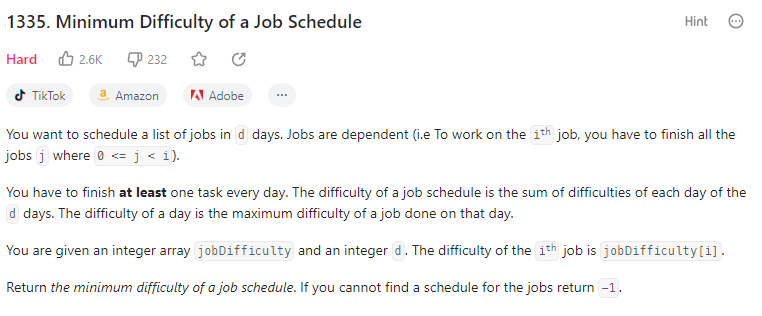
  
* implementation of top down
  + This is a DP problem, because the choice of each day affects the later day's schedule and the final resutls
    + two state variables, one is to define the starting index of the current day, the second is how many days are remaining
    + if the remaining day is zero, returns -1
    + if the remaining day is one, returns the max of the remaining job difficulties
    + for each function schedule(index, remain_day), it checks all the possibility of taking one to n-remain_day+1 jobs where n is the total number of jobs, translating to the index is current index to n-remaining_day (remember, index is 0 based). For example, if the current index is 2, and we have 3 remaining days, with totally 5 tasks, then the last index we can get to is 2, so `for i in range(index, n-remaining_day +1)` here index = 2, n=5, remaining_day = 3, so we have the for loop execute once to just pick up one task, since the two remaining tasks (indexed at 3 and 4) will need to be assigned to the other 2 reamining days
  + To avoid the TLE, set the maxsize of lru_cache to be None, so that the cache size will increase indefinitely with the entries
  + Therefore, it is a correct implementation, but due to the recursive stack, the runtime performance is not good enough
* implementation of bottom up 
  + Same thing to top down to build the max_arr that contains the max element starting from the corresponding index to the end of the array
  + we initialize a 2D DP array with n rows and d+1 columns. Each element has the default value of -1, which is the return value if schedule is not possible. 
    + assigning default values to -1 is not necessary, since the no-answer cases have been excluded by the first statement 
  + Each row refers to a starting index of the jobs, and each column refer to the day from which to schedule the job. For example, dp(0)(3) means to schedule jobs starting from the first job (index = 0) from day 3. 
    + note that we don't use day 0, we use day columns from day 1 to day == d, which is the last day. This is just for convenience to organize code and count days
    + The final results will be dp(0)(1) meaning the minimum total job difficulty to schedule starting from the first job and the first day
  + in DP, for each day's schedule, the starting job index is restricted to be in the range of d-1 to n-1. This is because for a specific day, we have to make sure there are jobs assigned to all the days before it, at least one job for each of the previous days. Therefore, for day 2, the earlies starting index will be 1, since job 0 has to be assigned to day 1
  + we first implemen the base case of the last column (column d) where the min difficult is the max elements of the corresponding job starting index in max_arr.
    + also, note that we start from d-1 to n, as the earliest job starting index is d-1
  + we then traverse the DP array, column by column from column d-1 to column 1 (remember day 0 will not be used)
  + in addition to the previous prinicple to traverse starting index from day-1, we also need to consider the end index to traverse because
    + these day variables are in the middle of day range, we have to leave sufficient jobs to the days afer the current day, which defines the end index to be n-(d-day)-1. For example, if d = 3, day = 2, and we have 5 jobs, n = 5, then for day 2, we can only traverse job indexes from 2 to 3, because job with index 4, which is the last job, must be kept for day 3
    + define max_ele as the max element so far that is initialized to jobDifficult(i)
    + set up internal loop for j to travese from i (starting index) to n-(d-day)-1,here j traverse on the dimension of job index for the current day.
  + apply tranistion equation of rs = min(rs, max_ele(j) + dp(j+1)(day+1)) for j in range \[i, n-(d-day)-1\]
    + max_ele(j) is the max element in jobDifficult list within the range \[i, j\] (from starting index of i to the current j job\[j\], inclusive, if we assign job j to the current day). This max_ele(j) is the cost/job difficulty of the current single day
    + the total difficulty of the current day needs to include another component, which is the total difficulty of the following days, which is dp(j+1)(day+1) 
    + this seems to be different than the commonly DP pattern that we either take or not take an element, but actually, they are the same. We will have to take at least on job for the current day, that is where we start the j loop from i as the starting index, we calculate the cost, we then test the cost of including the following day, and compare them to the current cost, which dose not include these days, and return the min cost for the current daty

In [1]:
# top down implementation
from typing import List

class Solution:
    def minDifficulty(self, jobDifficulty: List[int], d: int) -> int:
        if not jobDifficulty or len(jobDifficulty) < d:
            return -1
        
        n = len(jobDifficulty)
        if d == n:
            return sum(jobDifficulty)
        
        max_arr = [0] * n
        max_ele = jobDifficulty[-1]
        for i in range(n-1, -1, -1):
            max_ele = max(max_ele, jobDifficulty[i])
            max_arr[i] = max_ele            
        
        # defin state variables as the starting index of the job
        # and how many days are remained. The value is the min of
        # the sum of job difficulties
        @lru_cache(None)
        def find_min(start:int, remain_day: int) -> int:
            # if not enough jobs to assign to each remaining day
            # return max of float as a non-solution
            if n - start < remain_day or remain_day == 0:
                return float("inf")
            
            # if nubmer of jobs == remain_day,
            # get the sum 
            if n-start == remain_day:
                return sum(jobDifficulty[start:])
            
            # if only one day ramin, assign all jobs to that day
            if remain_day == 1:
                return max_arr[start]
            
            # try every cutting point by including
            # the cutting point in the first section
            max_ele = jobDifficulty[start]
            rs = float("inf")

            # we need the jobs in [start+1, n-1] to be assined in remain - 1 days
            # therefore, the last index we can scan for start index is n-start-1 == remain -1, 
            # therefore, we scan i in range [start, n-remain] 
            for i in range(start, n-remain_day+1):
                # include job i to the first part as max_ele
                max_ele = max(max_ele, jobDifficulty[i])

                # get sum of the two parts as the answer
                rs = min(rs, max_ele + find_min(i+1, remain_day-1))
            return rs
        
        return find_min(0, d)
                        

In [3]:
# bottom up implementation

from typing import List
class Solution:
    def minDifficulty(self, jobDifficulty: List[int], d: int) -> int:
        if not jobDifficulty or len(jobDifficulty) < d:
            return -1
        
        n = len(jobDifficulty)
        if d == n:
            return sum(jobDifficulty)
        
        dp = [[-1] * (d+1) for _ in range(n)]
        max_arr = [0] * n              
        max_ele = jobDifficulty[-1]
                   
        for i in range(n-1, -1, -1):
            max_ele = max(max_ele, jobDifficulty[i])
            max_arr[i] = max_ele            
        
        for i in range(d-1, n):
            dp[i][d] = max_arr[i]
            
        for day in range(d-1, 0, -1):
            for i in range(day-1, n):
                rs = float("inf")
                max_ele = jobDifficulty[i]
                for j in range(i, n-1):
                    max_ele = max(max_ele, jobDifficulty[j])
                    
                    rs = min(rs, max_ele + dp[j+1][day+1] )
                dp[i][day] = rs                
        
        return dp[0][1]         

### Leetcode 322 Coin Change
* overview
  + given an integer array coins representing coins of different denominations and an integer amount representing a total amount of money
  + return the fewest number of coins you need to make up that amount
* implementation
  + 1D DP problem. Establish an array with the number of elements equals to amount +1, with default element values of -1
  + the first element (index 0) has a value of 0, corresponding to the number of coins needed to get 0
  + traverse from 1 to amount, and each time, traverse all the coins to find all possible coin that can get one of the previous element with a value >-1
  + find the min of all these previous elements, and add one. This means that finding the fewest number of coins that can get one of the amount previous to the current amount by add on extra coin
  + return dp(amount)
* time complexity:
  + O(amount * len(coins))
* space complexity:
  + O(amount)

In [1]:
# bottom up
from typing import List
class Solution:
    def coinChange(self, coins: List[int], amount: int) -> int:
        if amount == 0:
            return 0
        
        dp = [-1] * (amount+1)
        dp[0] = 0
        
        for i in range(1, amount+1):
            pre = [dp[i-coin] for coin in coins if coin <= i and dp[i-coin] > -1]
            if pre:
                dp[i] = min(pre) + 1
                
        return dp[amount]        

# top down
from functools import lru_cache


class Solution:
    def coinChange(self, coins: List[int], amount: int) -> int:

        @lru_cache(None)
        def dfs(rem):
            if rem < 0:
                return -1
            if rem == 0:
                return 0
            min_cost = float('inf')
            for coin in coins:
                res = dfs(rem - coin)
                if res != -1:
                    min_cost = min(min_cost, res + 1)
            return min_cost if min_cost != float('inf') else -1

        return dfs(amount)

### Leetcode 139 Word break
* general overview
  + Given a string s and a dictionary of strings wordDict, return true if s can be segmented into a space-separated sequence of one or more dictionary words
  + Note that the same word in the dictionary may be reused multiple times in the segmentation
  + example: s = "leetcode", wordDict=\["leet", "code"\]
    + here s can be segmented into leet and code from wordDict
* algorithm
  + this is a DP problem, since
    + the final answer of the entire s string can be decomposed into sub-problems of substrings
    + the choice of how to segment the s string in index n will impact the segment of substrings after index n
  + state variable
    + the index of s string with true or false indicating if it is possible to express the substring up to that index by wrods from the wordDict
    + traverse i from 0 and check if s\[:i+1\] can be decomposed from words in wordDict and assign the results to dp(i)
    + return dp(-1)
  + recurrent function
    ```python
        for word in wordDict:
            if i >= len(word) and (i == len(word)-1 or dp[i-len(word)]):
                if s[i-len(word)+1:i+1] == word:
                    dp[i] = True
                    break
    ```                
* time complexity
  + O(nkl) where n, k and l are the length of string s, the number of words in wordDict, and the average length of the words in wordDict, respectively
* space complexity
  + O(n)

In [1]:
from typing import List

# bottom up implementation
class Solution:
    def wordBreak(self, s: str, wordDict: List[str]) -> bool:
        if not wordDict and not s:
            return True
        if not wordDict or not s:
            return False
        
        n = len(s)
        dp = [False] * n
        
        for i in range(n):
            for word in wordDict:
                if i >= len(word)-1 and (i==len(word) -1 or dp[i-len(word)]):
                    if s[i-len(word)+1: i+1] == word:
                        dp[i] = True
                        break
        return dp[-1]                  
# a simplified bottom up solution defining state variable i as the number
# of letters used in s string and whether or not the substring can 
# be obtained from wordDict

class Solution:
    def wordBreak(self, s: str, wordDict: List[str]) -> bool:
        if not s and not wordDict:
            return True

        n = len(s)

        # initialize dp to have n + 1 elements as False
        # each element corresponds to true or false if
        # we can obtain the s with i characters from wordDict
        dp = [False] * (n + 1)
        
        # initialize empty string as True
        dp[0] = True

        for i in range(1, n + 1):
            for word in wordDict:
                l = len(word)
                if i < l:
                    continue
                # dp[i-l] is the boolen value of using
                # i-l letters, if that is Ture, then we
                # check if [i-l, i-1] in s == word. Note
                # that there are i-l letters before s[i-1]
                # since the s[i] is 0-indexed
                if dp[i-l] and s[i-l:i] == word:
                    dp[i] = True
                    break
        return dp[n]                    
    
# top down
class Solution:
    def wordBreak(self, s: str, wordDict: List[str]) -> bool:
        n = len(s)
        
        @lru_cache
        def dp(i: int) -> bool:
            if i < 0:
                return True
            
            for word in wordDict:
                l = len(word)
                if i >= l-1 and dp(i-l):
                    if s[i-l+1:i+1] == word:
                        return True
            return False
        
        return dp(n-1)
        

### Leetcode 300 Longest increasing subsequence
* overview
  + Given an integer array nums, return the length of the longest strictly increasing subsequence  
* algorithm (DP)
  + using the index of the num in nums as state variable. Each DP element stores the longest increasing subsequence length till its index
  + initialize DP elements to be 1
  + traverse DP, for each element i, check all elements j before it, and assign it the max value of max(dp(i), dp(j)+1)
  + return the max(dp)
  + time complexity
    + O(n^2)
    + traverse each element of the n elements O(n), and each traverse requires to check all elements before it, which is O(n) by iteself, and therefore, is O(n^2)
  + space complexity
    + O(n)
    
    

In [1]:
# DP implementation

from typing import List
class Solution:
    def lengthOfLIS(self, nums: List[int]) -> int:
        n = len(nums)
        
        dp = [1] * n
        
        for i in range(1, n):
            for j in range(i):
                if nums[j] < nums[i]:
                    dp[i] = max(dp[i], dp[j]+1)
                    
        return max(dp)           
        

* patience sorting (or insert sorting)
  + re-arrange the orignial array to a new, ordered array
  + we first insert the first element to the first element of the new array
  + we then traverse to the next element. 
    + If it is smaller than the previous one, there is no way we can construct an increase subsequence consisting both of them, so we replace the previous element with the current one 
    + otherwise, we can use the previous and the current in an increase subsequence, so we insert the current one to the new array
 + after traversing the original element, return the lenght of the new array
 
* using binary search for patience sorting
  + we first initialize i, j to be zeros, which defines the starting and end indexes of the new array
    + we also initialize index = 0, which marks the end index of the new array, since i and j will be changed in binary searach. We will always search from i==0, but each time, we only search to the last element of the current new array, which is marked by index
  + when we traverse the array, we need to find its index in the new array. The index corresponds to the first element not smaller than the current num. This is because we can use the num to combine with all elements smaller than it as an increasing subsequence, and therefore, we can use num to replace the elements equal to or bigger than it in its position.
  + assign dp(i) = num after the binary search loop, since now i==j and i is the position of num in the new array
  + we then check if i == index, which is the last element in the current new array, if so, we expand the current new array by incrementing index
* important notes
  + in patience sorting, the state variable is still index of element, but dp(i) is the smallest ending number of a subsequence that has length i+1
    + dp(0) is the smallest ending element of all subsequences with a lenght of 1
    + dp(1) is the smallest ending element of all subsequences with a length of 2
    + that is why we use the binary search template to find the position of each num corresponding to the first position that is not smaller than num, and insert it to that position. If the position is 
  + index is the length of the new array, so if i == index, that means the new array is expanded, we need to increment index. Otherwise, num just replaces one of the existing element in new array, we don't need to do anything 
* time complexity:
  + O(nlog(n)
  + we traverse num in nums, which is O(n), and for each iteration, we use binary search to find its position, which is O(log(n)), and therefore, we have O(nlog(n))
* space complexity:
  + O(n) 

In [2]:
# binary search implementation

from typing import List

class Solution:
    def lengthOfLIS(self, nums: List[int]) -> int:
        n = len(nums)
        
        dp = [0] * n
        
        # initialize i, j and index to be 0
        # i, j, and index correspond to the start and length of current new array
        # note that we will traverse from i to j (not end index) in binary search
        i , j, index = 0, 0, 0
        
        # find the postion of num in the current new array 
        # (the position of the 1st element not smaller than num)
        for num in nums:
            i , j = 0, index
            while i < j:
                mid = (j-i)//2 + i
                if dp[mid] >= num:
                    j = mid
                else:
                    i = mid+1
            
            # assign num to the the position found in new array
            dp[i] = num
            
            # if i == index, then the current array is extended, and we increment index
            if i == index:
                index += 1
        
        return index        
        

### State Transition by Inaction (doing nothing)
* doing nothing refers to two different states having the same value
  + refers to the situation where we arrive at a new state with the same value as the previous state by doing nothing
  + this is the same as dp(i) = dp(i-1). One example is in house robber when not robbing is the best decision 

### Leetcode 188 Best Time to Buy and Sell Stock IV 
* overview
  + you are given an integer array prices where price(i) is the price of a given stock on the ith day, and an integer k
  + find the maximum profit you can achieve. you may complete at most k transactions: you may buy at most k times and sell at most k times
  + you must sell the stock before you buy again
* Algorithm (DP)
  + state variables
    + the current index of the day
    + how many transactions remained
    + are we holding a stock
      + if we are holding a stock, we have the options to keep it or sell it
      + if we don't hold stocks, we have the options to either buy today's stock or not buy
      
  + recurrent function
    + key point for this problem is that we will consistenly count a transaction completed only when we sell a stock
      + when we buy a stock, we don't count it as a transaction. In this way, we can update transactions
    + dp(0, k, 0) is the result, which will call to retrieve the value on day 1
    + for any dp(i, k, 0), we will get the value from max(dp(i+1, k, 0), dp(i+1, k, 1) - prices\[i\])
    + for any dp(i, k, 1), we will get the value from max(dp(i+1, k, 1), dp(i+1, k-1, 0) + prices\[i\])
    + the result will be dp(0, k, 0)
  + base case:
    + if k==0 or i = len(prices), return 0
    + here k ==0 we return 0 because even though dp(i, 0, hold) may not equals to zero, it must equals to dp(j, 0, hold) where j is a value < i, so we don't need to calculate it
    
* bottom up:
  + we will return dp(0)(k)(0)
  + since we know i == n and k == 0, dp(i)(k)(holding) = 0, we traverse i from n-1, j from 1.
  + for each cell, we first get holding\_value = dp(i+1)(j)(holding), then based on holding value, we get
    + if holding == 1, dp(i)(j)(holding) = max(dp(i+1)(j-1)(0)+prices(i), holding\_value)
    + if holding == 0, dp(i)(j)(holding) = max(dp(i+1)(j)(1) - prices(i), holding\_value)
  + return dp(0)(k)(0)  

In [13]:
# top down     
class Solution:
    def maxProfit(self, k: int, prices: List[int]) -> int:
        if k==0 or not prices:
            return 0

        @lru_cache(None)
        def dp(i, k, hold) -> int:
            if i == len(prices) or k == 0:
                return 0

            if hold == 1:
                return max(dp(i+1, k, 1), dp(i+1, k-1, 0) + prices[i])  
            else:
                return max(dp(i+1, k, 0), dp(i+1, k, 1) - prices[i])         

        return dp(0, k, 0)         

In [14]:
# bottom up
class Solution:
    def maxProfit(self, k: int, prices: List[int]) -> int:
        if k == 0 or not prices:
            return 0
        
        n = len(prices)
        
        dp = [[[0] * 2 for _ in range(k+1)] for _ in range(n+1)]
        
        for i in range(n-1, -1, -1):
            for j in range(1, k+1):
                for holding in range(2):
                    holding_value = dp[i+1][j][holding]
                    if holding == 1:
                        dp[i][j][holding] = max(dp[i+1][j-1][0] + prices[i], holding_value)
                    else:
                        dp[i][j][holding] = max(dp[i+1][j][1] - prices[i], holding_value)
                        
        return dp[0][k][0]                   
        

### Leetcode 309 Best Time to Buy and Sell Stock with Cooldown
* overview
  + you are given an array prices where prices(i) is the price of a given stock on the ith day
  + find the maximum profit you can achieve. You may complete as many transactions as you like with the following restrictions:
    + after you sell your stock, you can not buy stock on the next day (colldown one day)
* algorithm (DP)
  + for i in range(i-1, -1, -1), we traverse holding, and cool_down
  + we first calculate the value if we do nothing. Note that cool_down will always be 0 no matter what the cool_down value is at day i
  + if we hold a stock, then we have the option to sell it, and we switch to cool_down =1
  + if we don't hold a stock, then if cool_down, we can not sell the stock, so the value equals to do nothing option
  + if we don't hold a stock, and cool_down is 0, we can buy a stock, which is linked to dp(i+1)(1)(0)-prices(i)
  + the key point is that we just link the day i to day i+1 based on cool down and holding status
  

In [17]:
# top down
class Solution:
    def maxProfit(self, prices: List[int]) -> int:
        if not prices:
            return 0
        
        n = len(prices)
        
        @lru_cache(None)
        def dp(day: int, holding: bool, cool: bool) -> int:
            if day == n:
                return 0
            
            # hoding will always have cool == 0, but if we sell, then we need to set/link the holding=0 and cool=1
            if holding:
                return max(dp(day+1, holding, 0), dp(day+1, 0, 1) + prices[day])
            
            # if not holding, if cool, we can only link to the next day's non_cool state
            else:
                if cool:
                    return dp(day+1, 0, 0)
                
                # else, we can buy the stock with cool=0 or just keep nonholding and noncool state
                else:
                    return max(dp(day+1, 1, 0) - prices[day], dp(day+1, 0 , 0))
        return dp(0, 0, 0)

In [16]:
# bottom up
class Solution:
    def maxProfit(self, prices: List[int]) -> int:
        if not prices:
            return 0
        n = len(prices)
        dp = [ [ [0] *2 for _ in range(2)] for _ in range(n+1)]
        
        for i in range(n-1, -1, -1):
            for holding in range(2):
                for cool_down in range(2):
                    rs = dp[i+1][holding][0]
                    if holding:
                        dp[i][holding][cool_down] = max(rs, dp[i+1][0][1] + prices[i])
                    else:
                        if cool_down:
                            dp[i][holding][cool_down] = rs
                        else:
                            dp[i][holding][cool_down] = max(rs, dp[i+1][1][0]-prices[i])
                            
        return dp[0][0][0]                    
                
        